### Задача 1
Поддерживать и стимулировать пользовательскую активность – важная задача для продукта, подобного нашему. Для этого наша команда маркетологов решила организовать флэшмоб в ленте новостей: участники должны сделать пост, где они рассказывают какой-то интересный факт о себе, и опубликовать его с хэштегом. Три поста, собравших наибольшее число лайков, получают призы.

Флэшмоб проходил с **2023-07-14** по **2023-07-20**. Ваша задача как аналитика – оценить эффективность этого мероприятия.

1) Предположите, какие метрики должны были измениться во время флэшмоба и как. Почему? Предложите не менее 5 метрик.

2) Проверьте, реально ли эти метрики изменились, используя CausalImpact. Если изменение действительно произошло - опишите, как именно изменилась метрика и насколько.

3) Необязательно: имел ли флэшмоб какие-то долгосрочные эффекты?

4) Сделайте выводы по полученным результатам.

### 1. Метрики

Во время проведения флэшмоба можно ожидать увеличения следующих метрик:

1) Количество просмотров в день. Флэшмоб направлен на стимулирование активности пользователей. Просмотры - это основной критерий активности.

2) CTR. Количество лайков - критерий выявления победителей, поэтому этот показатель должен вырасти в большей степени, чем просмотры. Соответственно, и CTR должен подрасти.

3) DAU. Флэшмоб должен как активизировать старых пользователей, в том числе тех, кто не заходил в приложение некоторое время, так и привлечь новых.

4) Новые пользователи. Как было сказано в пункте 3, флэшмоб должен привлечь новых пользователей. В частности, участики будут просить своих друзей и знакомых зарегистрироваться в приложении и поддержать их посты лайками.

5) Новые посты. На первый взгляд кажется, что количество новых постов на стандартные для пользователей приложения темы должно остаться примерно на старом уровне, но при этом должен произойти существенный прирост за счет новых постов на тему флэшмоба.

6) Количество пользовательских действий на пост. Просмотров и лайков у флэшмобных постов должно быть существенно больше, чем у стандартных. Соответственно в среднем за день эта метрика тоже увеличится.

Сразу обозначим, что при проверке изменения этих метрик с помощью CasualImpact было бы правильно включать в модели ковариаты. При этом важно, чтобы они не были подвержены тому же воздействию, что и проверяемая метрика. В нашем же случае флэшмоб был организован для всех пользователей приложения, поэтому определить какие-либо метрики, которые не были подвержены его воздействию довольно сложно. В связи с этим, в рамках текущей работы включать регрессоры в модели не будем.
****

### 2. Проверка изменения с помощью CasualImpact

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import pandahouse as ph
from causalimpact import CausalImpact
import tensorflow as tf
import tensorflow_probability as tfp

In [2]:
# Выгрузим необходимые данные
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'******',
                      'user':'student', 
                      'password':'******'
                     }

query = '''
SELECT 
    t.day as day
    ,views
    ,CTR
    ,DAU    
    ,new_users_count
    ,new_posts_count
    ,actions_per_post
FROM
    (select 
        toDate(time) as day
        ,uniqExact(user_id) as DAU
        ,countIf(action = 'like') as likes
        ,countIf(action = 'view') as views
        ,count(user_id) as actions
        ,uniqExact(post_id) as unique_posts
        ,likes/views as CTR
        ,actions/unique_posts as actions_per_post
    from {db}.feed_actions 
    group by toDate(time)) as t
    inner join
    (select
        day
        ,count(post_id) as new_posts_count
    from
        (select
            post_id
            ,min(toDate(time)) as day
        from {db}.feed_actions
        group by 
            post_id) as t2
    group by day) as posts
    ON t.day = posts.day
    inner join
    (select
        day
        ,count(user_id) as new_users_count
    from
        (select
            user_id
            ,min(toDate(time)) as day
        from {db}.feed_actions
        group by 
            user_id) as t2
    group by day) as users
    ON users.day = t.day
WHERE day < '2023-08-01'
'''

df = ph.read_clickhouse(query, connection=connection).set_index('day')
df.head()

,views,CTR,DAU,new_users_count,new_posts_count,actions_per_post
day,,,,,,
2023-06-03,7603,0.205182,878,878,89,102.955056
2023-06-04,62770,0.204174,2238,1819,97,424.640449
2023-06-05,105526,0.198605,3105,1849,61,662.219895
2023-06-06,118996,0.200007,3721,1652,87,676.758294
2023-06-07,174454,0.197783,4617,1809,70,976.439252


In [3]:
# Сохраним пре- и пост- периоды для моделей
pre_period = ['2023-06-03', '2023-07-13']
post_period = ['2023-07-14', '2023-07-20']

****

### 2.1. Просмотры

<Axes: xlabel='day', ylabel='views'>

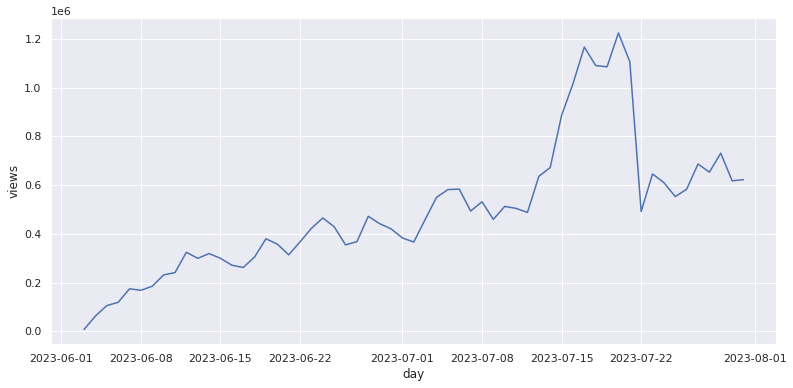

In [5]:
# Визуализируем подневную динамику просмотров
sns.set(rc={'figure.figsize':(13, 6)})

sns.lineplot(data = df, x='day', y = 'views')

Невооруженным взглядом виден рост числа просмотров в период флэшмоба. Попробуем оценить его с помощью CasualImpact

In [ ]:
# Применим модель по умолчанию. В качестве аргумента укажем недельную сезонность
ci_views = CausalImpact(df.views, pre_period, post_period, model_args = {'nseasons':7})

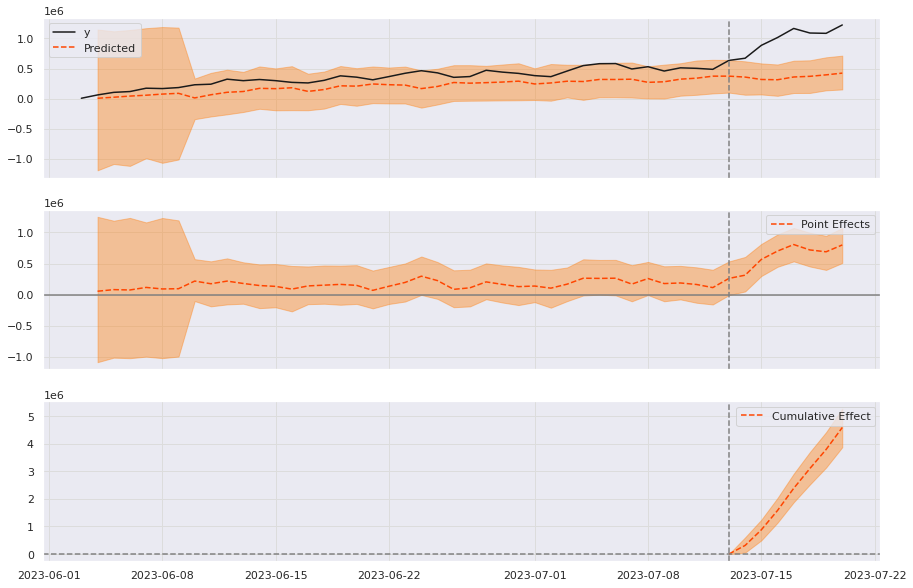

In [7]:
ci_views.plot(figsize=(15, 10))

In [8]:
print(ci_views.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         363774.44 (49637.4)2546421.0 (347461.76)
95% CI                    [264704.3, 459279.36][1852930.12, 3214955.47]

Absolute effect (s.d.)    656172.88 (49637.4)4593210.0 (347461.76)
95% CI                    [560667.95, 755243.01][3924675.53, 5286700.88]

Relative effect (s.d.)    180.38% (13.65%)   180.38% (13.65%)
95% CI                    [154.13%, 207.61%] [154.13%, 207.61%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


На первом и втором графиках видим, что прогнозные значения модели всегда ниже, чем фактические. Это связано с тем, что по умолчанию модель CausalImpact предполагает, что временной ряд держится на каком-то постоянном уровне. Тем же обусловлено и очень большое значение относительного эффекта от флэшмоба - около 180%.

При этом нам известно, что в период до флэшмоба количество просмотров имело тренд на повышение, поэтому необходимо попробовать **кастомизировать модель**.

In [9]:
# Строим модель, учитывающую тренд
reg_dated_data = tfp.sts.regularize_series(df.views.loc[:'2023-07-13'].astype('float32')) # Без этого построение моделей STS выдает ошибку
trend_component = tfp.sts.LocalLinearTrend(observed_time_series = reg_dated_data) # моделируем тренд
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=reg_dated_data) # моделируем недельную сезонность
model = tfp.sts.Sum([trend_component, seasonal], observed_time_series=reg_dated_data) # собираем модель

# Добавляем модель в качестве аргумента в функцию CausalImpact
ci_views_custom = CausalImpact(df.views, pre_period, post_period, model = model, model_args = {'standardize':False})

2023-08-09 19:11:47.235706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1' with dtype int32 and shape [2]
	 [[{{node AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/while/strided_slice/AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/concat_1}}]]
2023-08-09 19:11:47.361463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'AdditiveStateSpaceModel/sample/AdditiveStateSpaceModel/sample_n_joint/scan/whil

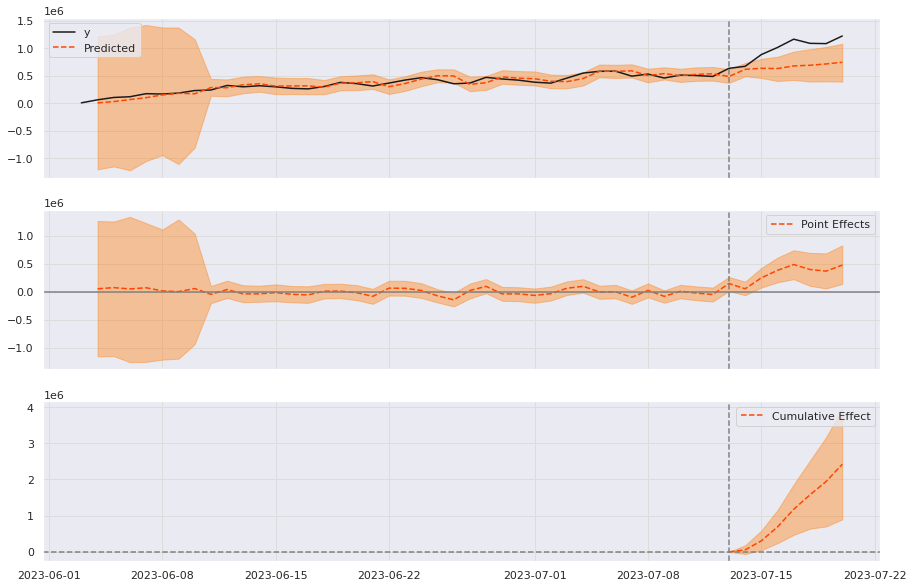

In [10]:
ci_views_custom.plot(figsize=(15, 10))

На основе графиков создается впечатление, что новая модель работает значительно лучше.

In [11]:
print(ci_views_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1019947.31         7139631.0
Prediction (s.d.)         673980.31 (109728.75)4717862.0 (768101.19)
95% CI                    [486300.58, 916429.44][3404104.04, 6415005.99]

Absolute effect (s.d.)    345967.0 (109728.75)2421769.0 (768101.19)
95% CI                    [103517.87, 533646.74][724625.01, 3735526.96]

Relative effect (s.d.)    51.33% (16.28%)    51.33% (16.28%)
95% CI                    [15.36%, 79.18%]   [15.36%, 79.18%]

Posterior tail-area probability p: 0.01
Posterior prob. of a causal effect: 98.9%

For more details run the command: print(impact.summary('report'))


**Вывод:**

Если бы флэшмоб не был организован, мы могли бы ожидать, что среднее количество просмотров в период с 14 по 20 июля должно быть около 673980 в день. 95% доверительный интервал для этого прогноза = [486300.58, 916429.44]. Фактическое значение этого показателя не попало в границы доверительного интервала и было равно 1019947.31 просмотров в день.

Таким образом, эффект от флешмоба составил в среднем 345967.0 просмотров в день (или 51.33%) при 95-процентном доверительном интервале, равном [103517.87, 533646.74]. Это говорит о том, что положительный эффект, который наблюдался в период флэшмоба статистически значим и практически наверняка не был обусловлен случайными колебаниями метрики.

****
### 2.2. CTR

<Axes: xlabel='day', ylabel='CTR'>

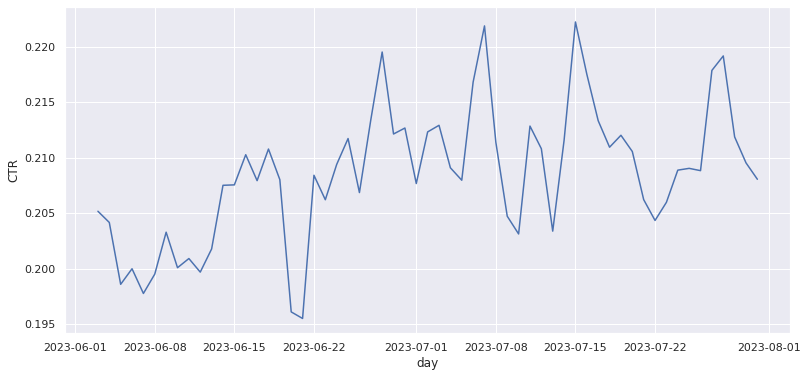

In [12]:
# Визуализируем подневную динамику CTR
sns.set(rc={'figure.figsize':(13, 6)})
sns.lineplot(data = df, x='day', y = 'CTR')

На основе графика довольно сложно делать какие-то выводы. Кажется, что во время флэшмоба CTR особо не изменился.

In [ ]:
# Применим модель по умолчанию
pre_period = ['2023-06-03', '2023-07-13']
post_period = ['2023-07-14', '2023-07-20']
ci_CTR = CausalImpact(df.CTR, pre_period, post_period)

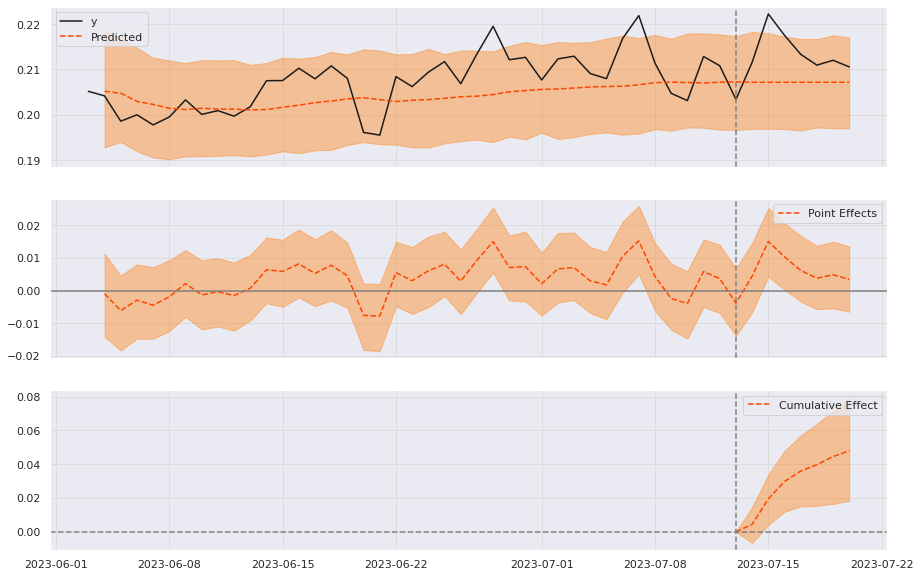

In [14]:
ci_CTR.plot(figsize=(15, 10))

In [15]:
print(ci_CTR.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.21 (0.0)         1.45 (0.02)
95% CI                    [0.2, 0.21]        [1.42, 1.48]

Absolute effect (s.d.)    0.01 (0.0)         0.05 (0.02)
95% CI                    [0.0, 0.01]        [0.02, 0.08]

Relative effect (s.d.)    3.31% (1.06%)      3.31% (1.06%)
95% CI                    [1.21%, 5.37%]     [1.21%, 5.37%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


Базовая модель увидела значимое повышение подневного CTR во время флэшмоба по сравнению с периодом до него на 3.31% (95-ти процентный доверительный интервал изменения = [1.21%, 5.37%]).

Однако на первом и втором графике видим, что в период с 22 июня по 8 июля предсказания модели были стабильно ниже факта. В тот же период было два дня, в которые значения CTR вышли за верхний предел доверительного интервала. На мой взгляд, это является основанием для того, чтобы усомниться в качестве прогнозной модели.

Попробуем кастомизировать модель, как и в случае с анализом изменения просмотров.

In [16]:
# Строим модель, учитывающую тренд
reg_dated_data = tfp.sts.regularize_series(df.CTR.loc[:'2023-07-13'].astype('float32')) # Без этого построение моделей STS выдает ошибку
trend_component = tfp.sts.LocalLinearTrend(observed_time_series = reg_dated_data) # моделируем тренд
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=reg_dated_data) # моделируем недельную сезонность
model = tfp.sts.Sum([trend_component, seasonal], observed_time_series=reg_dated_data) # собираем модель

# Добавляем модель в качестве аргумента в функцию CausalImpact
ci_CTR_custom = CausalImpact(df.CTR, pre_period, post_period, model = trend_component, model_args = {'standardize':False})

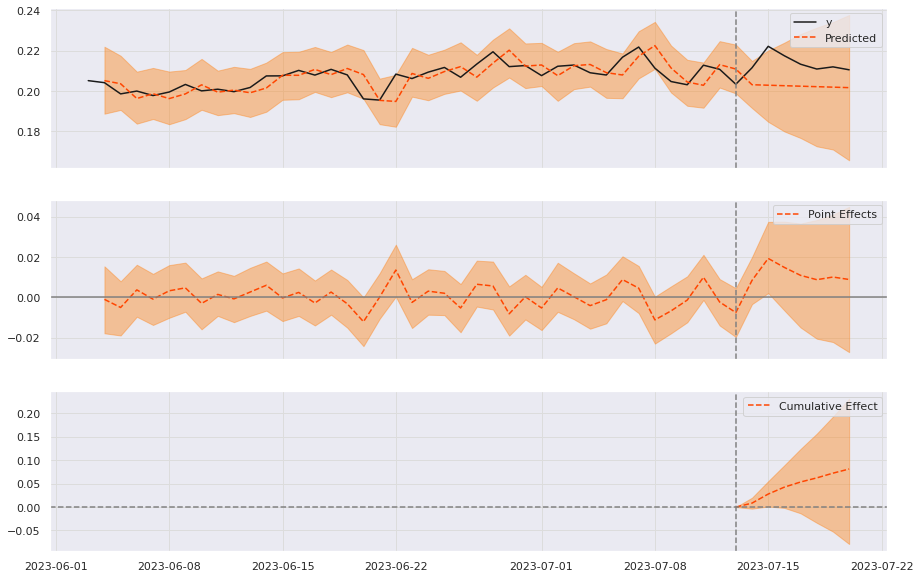

In [17]:
ci_CTR_custom.plot(figsize=(15, 10))

In [18]:
print(ci_CTR_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    0.21               1.5
Prediction (s.d.)         0.2 (0.01)         1.42 (0.08)
95% CI                    [0.18, 0.22]       [1.27, 1.57]

Absolute effect (s.d.)    0.01 (0.01)        0.08 (0.08)
95% CI                    [-0.01, 0.03]      [-0.07, 0.23]

Relative effect (s.d.)    5.73% (5.45%)      5.73% (5.45%)
95% CI                    [-5.18%, 16.2%]    [-5.18%, 16.2%]

Posterior tail-area probability p: 0.15
Posterior prob. of a causal effect: 84.62%

For more details run the command: print(impact.summary('report'))


**Вывод:**

Разница фактического CTR во время флэшмоба и прогноза новой модели оказалась больше, чем в случае с моделью по умолчанию: 5.73% против 3,31%.

Однако прогноз новой модели имеет намного более широкий 95-процентный доверительный интервал: [0.18, 0.22] вместо [0.2, 0.21] у обычной. В связи с этим она не считает повышение метрики значимым.

Таким образом, повышение подневного CTR во время флэшмоба имело место, но у нас не досточно оснований считать, что оно было связано именно с этим событием.

****
### 2.3. DAU

<Axes: xlabel='day', ylabel='DAU'>

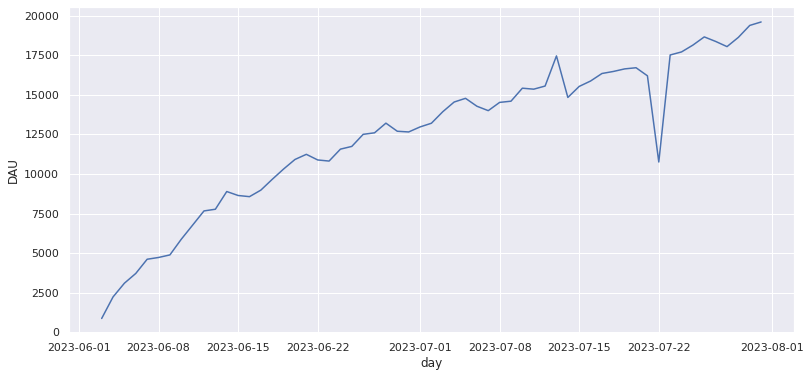

In [19]:
# Визуализируем подневную динамику DAU
sns.set(rc={'figure.figsize':(13, 6)})
sns.lineplot(data = df, x='day', y = 'DAU')

DAU имеет явный тренд на повышение: сразу применим кастомную модель.

In [ ]:
# Строим модель, учитывающую тренд
reg_dated_data = tfp.sts.regularize_series(df.DAU.loc[:'2023-07-13'].astype('float32')) # Без этого построение моделей STS выдает ошибку
trend_component = tfp.sts.LocalLinearTrend(observed_time_series = reg_dated_data) # моделируем тренд
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=reg_dated_data) # моделируем недельную сезонность
model = tfp.sts.Sum([trend_component, seasonal], observed_time_series=reg_dated_data) # собираем модель

# Добавляем модель в качестве аргумента в функцию CausalImpact
ci_DAU_custom = CausalImpact(df.DAU, pre_period, post_period, model = trend_component, model_args = {'standardize':False})

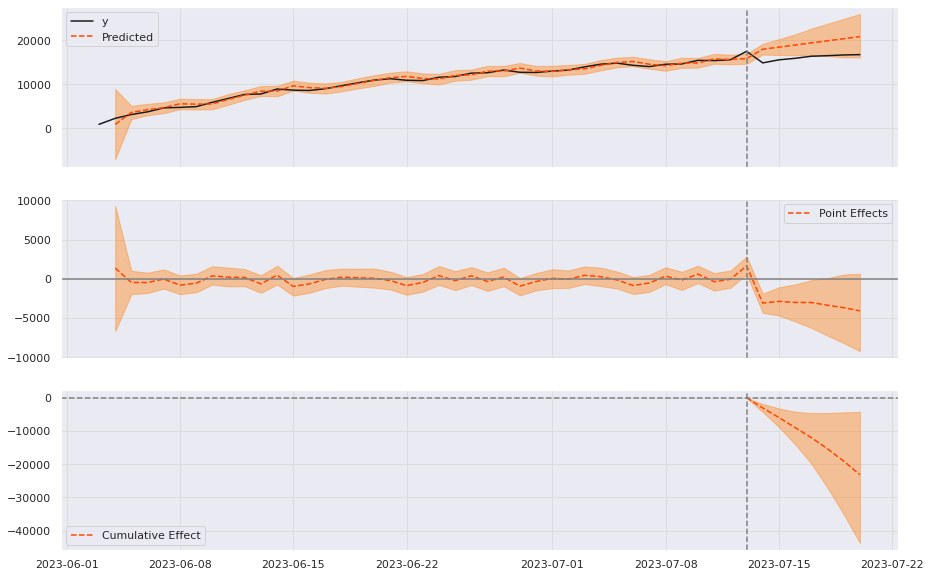

In [21]:
ci_DAU_custom.plot(figsize=(15, 10))

In [22]:
print(ci_DAU_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         19363.88 (1395.11) 135547.19 (9765.75)
95% CI                    [16831.67, 22300.39][117821.71, 156102.74]

Absolute effect (s.d.)    -3311.17 (1395.11) -23178.19 (9765.75)
95% CI                    [-6247.68, -778.96][-43733.74, -5452.71]

Relative effect (s.d.)    -17.1% (7.2%)      -17.1% (7.2%)
95% CI                    [-32.26%, -4.02%]  [-32.26%, -4.02%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.7%

For more details run the command: print(impact.summary('report'))


Модель показала, что во время флэшмоба произошло значимое падение DAU. Это неожиданно. Правда, нужно вспомнить, что 13 июля был аномальный всплеск этой метрики. Можем построить новую модель, в которой не будем его учитывать.

In [ ]:
# уберем выброс из данных, заменив на предыдущее значение
DAU_no_anomaly = df.DAU.copy()
DAU_no_anomaly.loc['2023-07-13'] = DAU_no_anomaly.loc['2023-07-12']

#Построим новую модель
reg_dated_data = tfp.sts.regularize_series(DAU_no_anomaly.loc[:'2023-07-13'].astype('float32')) # Без этого построение моделей STS выдает ошибку
trend_component = tfp.sts.LocalLinearTrend(observed_time_series = reg_dated_data) # моделируем тренд
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=reg_dated_data) # моделируем недельную сезонность
model = tfp.sts.Sum([trend_component, seasonal], observed_time_series=reg_dated_data) # собираем модель

# Добавляем модель в качестве аргумента в функцию CausalImpact
ci_DAU_no_anomaly = CausalImpact(DAU_no_anomaly, pre_period, post_period, model = trend_component, model_args = {'standardize':False})

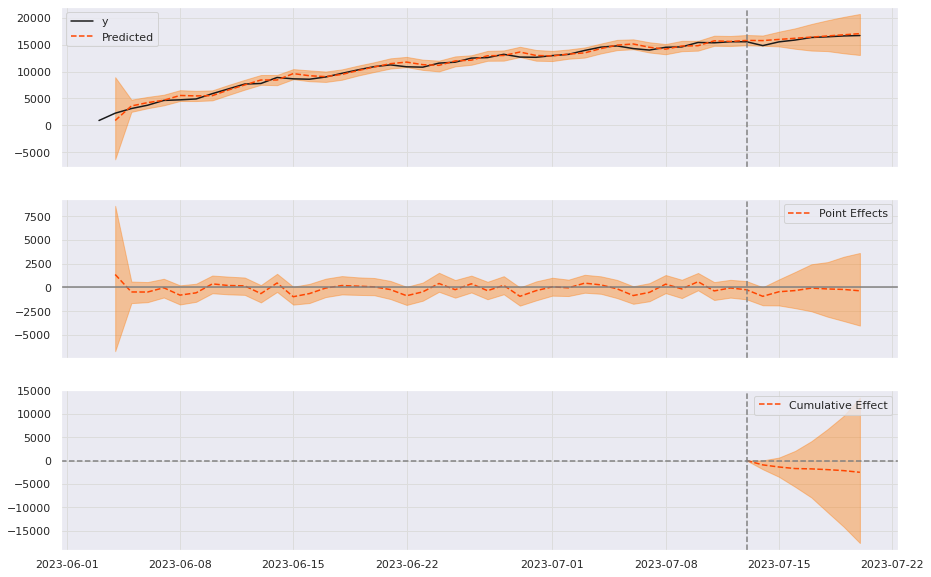

In [24]:
ci_DAU_no_anomaly.plot(figsize=(15, 10))

In [25]:
print(ci_DAU_no_anomaly.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    16052.71           112369.0
Prediction (s.d.)         16413.69 (1157.0)  114895.81 (8099.0)
95% CI                    [14002.75, 18538.1][98019.23, 129766.72]

Absolute effect (s.d.)    -360.97 (1157.0)   -2526.81 (8099.0)
95% CI                    [-2485.39, 2049.97][-17397.72, 14349.77]

Relative effect (s.d.)    -2.2% (7.05%)      -2.2% (7.05%)
95% CI                    [-15.14%, 12.49%]  [-15.14%, 12.49%]

Posterior tail-area probability p: 0.38
Posterior prob. of a causal effect: 62.34%

For more details run the command: print(impact.summary('report'))


**Вывод:**

Модель, обученная на данных без выброса, тоже зафиксировала падение метрики, но не сочла его значительным (-360.97 при 95% доверительном интервале от -2485.39 до 2049.97).

Таким образом, у нас нет оснований считать, что флэшмоб каким-то образом повлиял на DAU.

****
### 2.4. Новые пользователи

<Axes: xlabel='day', ylabel='new_users_count'>

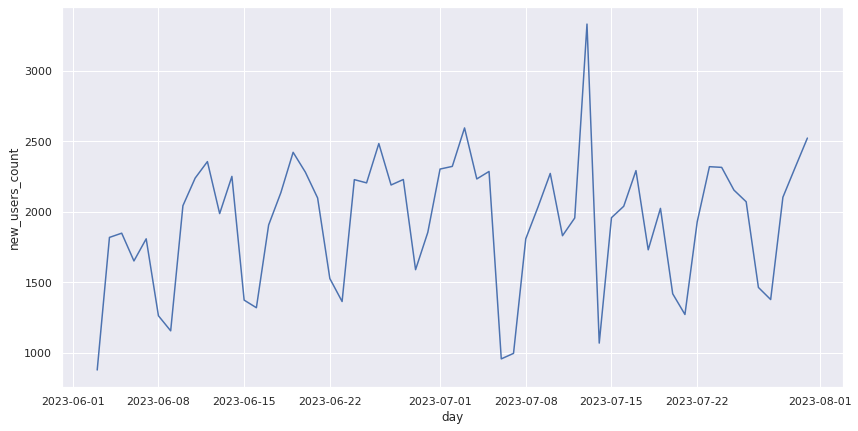

In [26]:
# Визуализируем подневную динамику новых пользователей
sns.set(rc={'figure.figsize':(14, 7)})
sns.lineplot(data = df, x='day', y = 'new_users_count')

В принципе значения метрики не имеют явного тренда. Можем пробовать базовую модель. Также на графике заметна недельная сезонность - укажем её в качестве аргумента модели.

Ещё один важный момент - аномальный всплеск новых пользователей 13 июля. Необходимо избавиться от его влияния на прогноз. Заменим его на среднее значение метрики за предыдущие три недели (с 21 июня по 12 июля).

In [ ]:
# формируем данные без аномалии
new_users_no_anomaly = df.new_users_count.copy()
new_users_no_anomaly.loc['2023-07-13'] = new_users_no_anomaly.loc['2023-06-21':'2023-07-12'].mean()

# применим CasualImpact
ci_new_users = CausalImpact(new_users_no_anomaly, pre_period, post_period, model_args = {'nseasons':7})

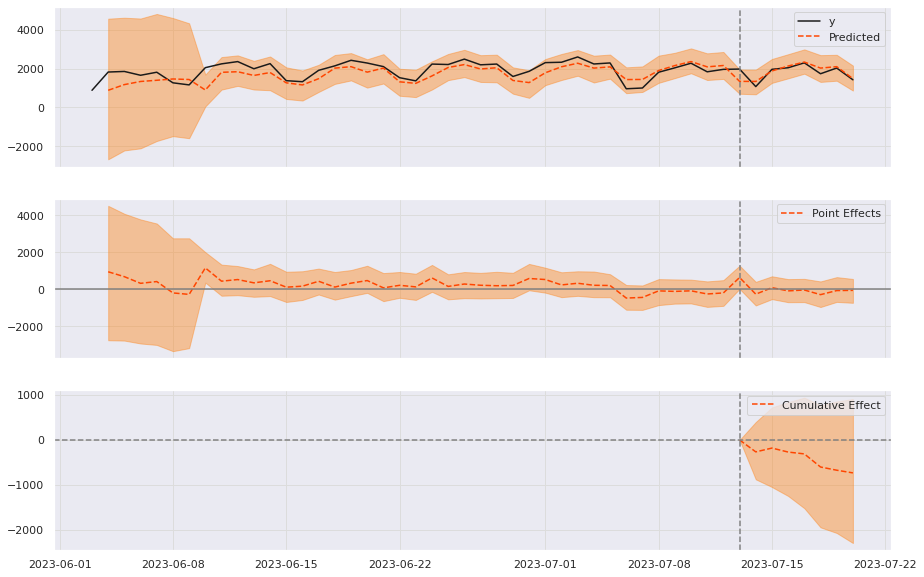

In [28]:
ci_new_users.plot(figsize=(15, 10))

In [29]:
print(ci_new_users.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    1790.86            12536.0
Prediction (s.d.)         1895.42 (119.54)   13267.96 (836.81)
95% CI                    [1667.37, 2135.98] [11671.62, 14951.86]

Absolute effect (s.d.)    -104.57 (119.54)   -731.96 (836.81)
95% CI                    [-345.12, 123.48]  [-2415.86, 864.38]

Relative effect (s.d.)    -5.52% (6.31%)     -5.52% (6.31%)
95% CI                    [-18.21%, 6.51%]   [-18.21%, 6.51%]

Posterior tail-area probability p: 0.17
Posterior prob. of a causal effect: 82.72%

For more details run the command: print(impact.summary('report'))


**Вывод:**

В период флэшмоба количество новых пользователей снизилось на 5.52% (95-ти процентный доверительный интервал = [-18.21%, 6.51%]). Мы не можем быть уверены, что это изменение связано с организованной акцией.

****
### 2.5. Новые посты

<Axes: xlabel='day', ylabel='new_posts_count'>

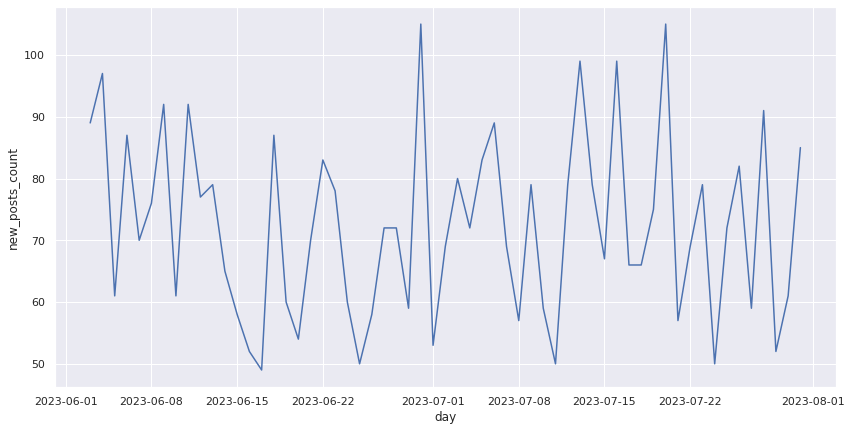

In [30]:
# Визуализируем подневную динамику новых постов
sns.set(rc={'figure.figsize':(14, 7)})
sns.lineplot(data = df, x='day', y = 'new_posts_count')

В принципе значения метрики не имеют явного тренда. Можем пробовать базовую модель.

In [ ]:
ci_new_posts = CausalImpact(df.new_posts_count, pre_period, post_period)

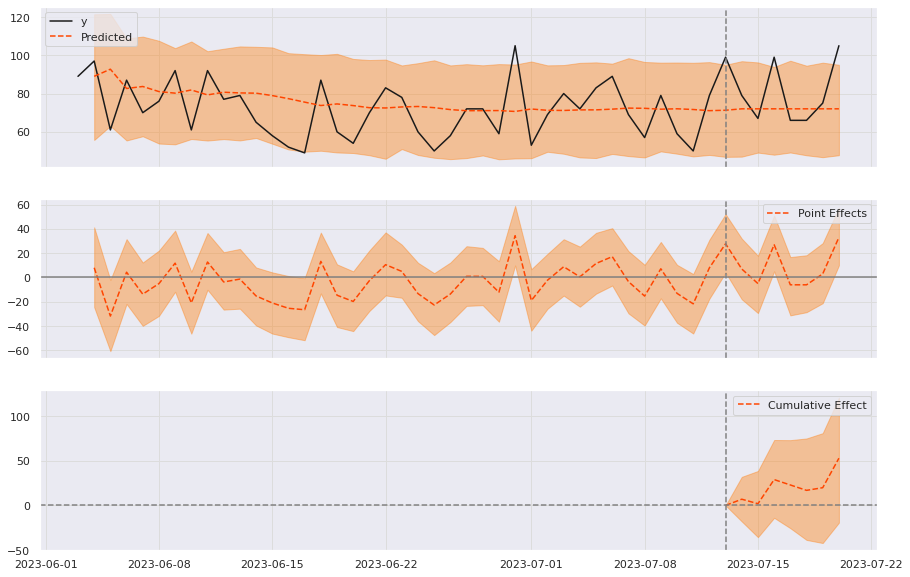

In [32]:
ci_new_posts.plot(figsize=(15, 10))

In [33]:
print(ci_new_posts.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    79.57              557.0
Prediction (s.d.)         72.02 (5.06)       504.17 (35.41)
95% CI                    [62.39, 82.22]     [436.73, 575.52]

Absolute effect (s.d.)    7.55 (5.06)        52.83 (35.41)
95% CI                    [-2.65, 17.18]     [-18.52, 120.27]

Relative effect (s.d.)    10.48% (7.02%)     10.48% (7.02%)
95% CI                    [-3.67%, 23.86%]   [-3.67%, 23.86%]

Posterior tail-area probability p: 0.06
Posterior prob. of a causal effect: 93.91%

For more details run the command: print(impact.summary('report'))


**Вывод:**

CausalImpact подсказывает, что в период флэшмоба количество новых постов в день выросло в среднем на 7,55 по сравнению с ожидаемым значением (на 53 поста за весь период). Кажется, что это не мало, но 95% доверительный интервал для прогнозного значения метрики включил в себя фактическое значение. Поэтому мы не имеем достаточных оснований считать, что полученный эффект был вызван именно флэшмобом.

При этом важно отметить, что в данном случае было бы не лишним использовать ковариаты в модели и/или каким-либо образом кастомизировать её с помощью TensorFlow Probability. Вполне возможно, что в этом случае мы бы зафиксировали статистически значимый эффект.

***
### 2.6. Среднее количество просмотров и лайков на пост

<Axes: xlabel='day', ylabel='actions_per_post'>

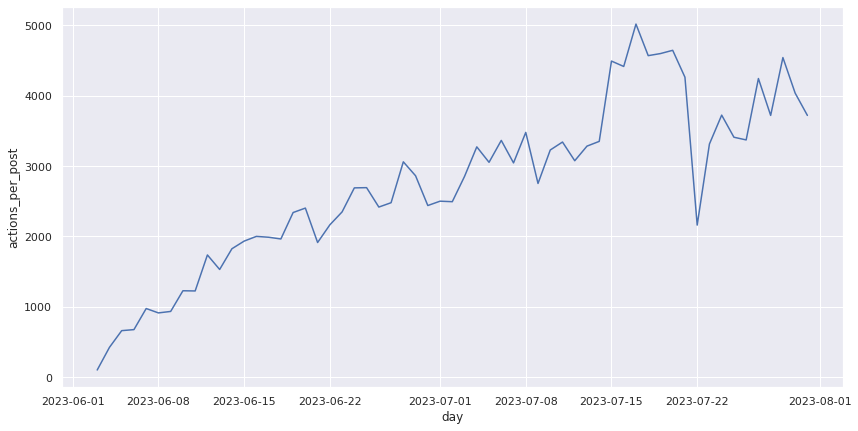

In [34]:
# Визуализируем подневную динамику новых постов
sns.set(rc={'figure.figsize':(14, 7)})
sns.lineplot(data = df, x='day', y = 'actions_per_post')

График похож на тот, который демонстрировал количество просмотров выше (п.2.1). В связи с этим, в рамках анализа применим ту же кастомную модель.

In [ ]:
# Строим модель, учитывающую тренд
reg_dated_data = tfp.sts.regularize_series(df.actions_per_post.loc[:'2023-07-13'].astype('float32')) # Без этого построение моделей STS выдает ошибку
trend_component = tfp.sts.LocalLinearTrend(observed_time_series = reg_dated_data) # моделируем тренд
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=reg_dated_data) # моделируем недельную сезонность
model = tfp.sts.Sum([trend_component, seasonal], observed_time_series=reg_dated_data) # собираем модель

# Добавляем модель в качестве аргумента в функцию CausalImpact
ci_actions_per_post_custom = CausalImpact(df.actions_per_post, pre_period, post_period, model = model, model_args = {'standardize':False})

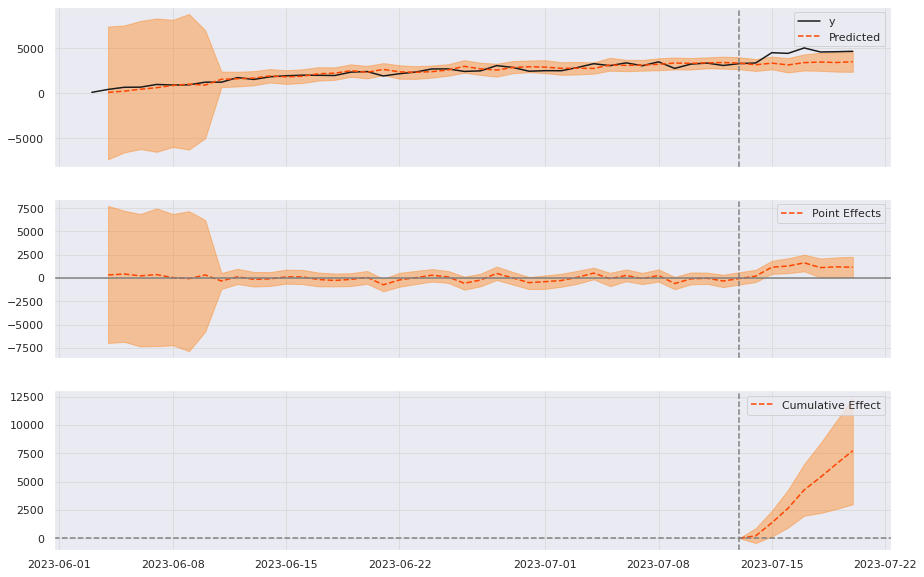

In [36]:
ci_actions_per_post_custom.plot(figsize=(15, 10))

In [37]:
print(ci_actions_per_post_custom.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    4441.6             31091.21
Prediction (s.d.)         3338.62 (340.31)   23370.36 (2382.18)
95% CI                    [2627.87, 3961.86] [18395.07, 27733.03]

Absolute effect (s.d.)    1102.98 (340.31)   7720.85 (2382.18)
95% CI                    [479.74, 1813.73]  [3358.18, 12696.14]

Relative effect (s.d.)    33.04% (10.19%)    33.04% (10.19%)
95% CI                    [14.37%, 54.33%]   [14.37%, 54.33%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 99.5%

For more details run the command: print(impact.summary('report'))


**Вывод:**

В период флэшмоба среднее количество просмотров и лайков на один пост в день увеличилось на 33.04% по сравнению с прогнозом. 95-процентный доверительный интервал прогноза ([2627.87, 3961.86]) не включает в себя фактическое значение. Таким образом, можем утверждать, что увеличение метрики обусловлено флэшмобом.

****
### 3. Долгосрочная перспектива

Из шести рассмотренных метрик только две в период проведения флэшмоба существенно выросли именно ввиду этого события: 

* количество просмотров в день;
* среднее количество пользовательских действий на пост. 

Однако остается открытым вопрос о том, был ли этот эффект долгосрочным.

Чтобы на него ответить, можем, как вариант, снова попробовать воспользоваться пакетом CasualImpact, увеличив pre-period модели до 20 июля, то есть до момента завершения флэшмоба, с заменой фактических данных в период флэшмоба на прогноз, полученный при проведенной оценке эффекта от этой акции. В качестве post-period возьмем следующие за окончанием флэшмоба даты. Если в результате анализа мы получим статистически значимый положительный эффект, то можно будет сделать вывод о существовании долгосрочного эффекта от флэшмоба.

Выполним описанные действия по отношению к количеству просмотров в день.

In [38]:
# Посмотрим на предсказания построенной выше модели (п.2.1.)
ci_views_custom.inferences['complete_preds_means'].loc['2023-07-14':'2023-07-20']

day
2023-07-14    617331.5625
2023-07-15    636287.6250
2023-07-16    631766.7500
2023-07-17    679211.7500
2023-07-18    691659.9375
2023-07-19    715640.2500
2023-07-20    745964.0000
Freq: D, Name: complete_preds_means, dtype: float32

In [39]:
# Формируем новые данные с заменой
views_predicted = df.views.copy()
views_predicted.loc['2023-07-14':'2023-07-20'] = ci_views_custom.inferences['complete_preds_means'].loc['2023-07-14':'2023-07-20']

In [ ]:
# Воссоздадим модель, использовавшуюся для оценки изменения количества просмотров
reg_dated_data = tfp.sts.regularize_series(df.views.loc[:'2023-07-13'].astype('float32')) # Без этого построение моделей STS выдает ошибку
trend_component = tfp.sts.LocalLinearTrend(observed_time_series = reg_dated_data) # моделируем тренд
seasonal = tfp.sts.Seasonal(num_seasons=7, observed_time_series=reg_dated_data) # моделируем недельную сезонность
model = tfp.sts.Sum([trend_component, seasonal], observed_time_series=reg_dated_data) # собираем модель

# Применим CasualImpact к новым данным и pre- и post- периодам
pre_period2 = ['2023-06-03', '2023-07-20']
post_period2 = ['2023-07-21', str(df.index.max())]
ci_views_custom_long_term = CausalImpact(views_predicted, pre_period2, post_period2, model = model, model_args = {'standardize':False})

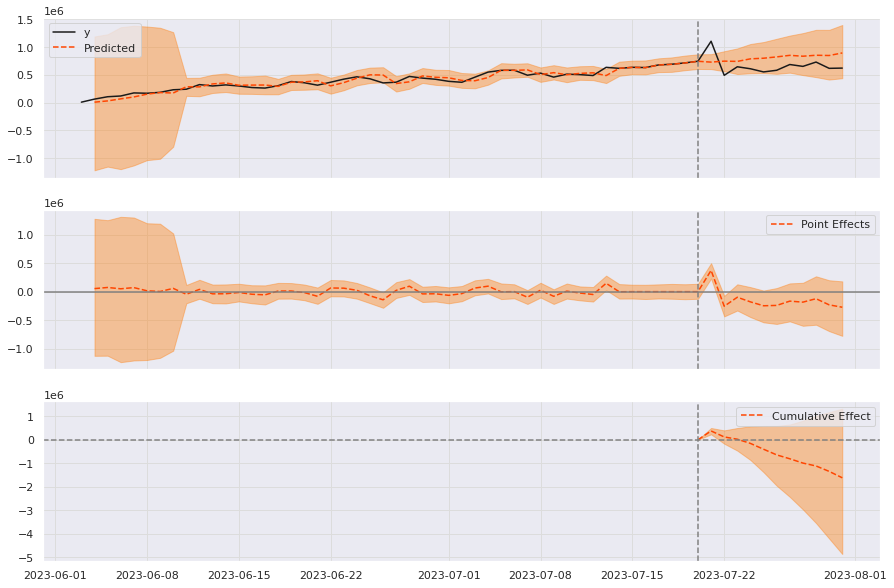

In [41]:
ci_views_custom_long_term.plot(figsize=(15, 10))

In [42]:
print(ci_views_custom_long_term.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    663616.19          7299778.0
Prediction (s.d.)         810866.75 (148656.83)8919534.0 (1635225.15)
95% CI                    [516165.29, 1098889.5][5677818.3, 12087784.45]

Absolute effect (s.d.)    -147250.56 (148656.83)-1619756.0 (1635225.15)
95% CI                    [-435273.31, 147450.9][-4788006.45, 1621959.7]

Relative effect (s.d.)    -18.16% (18.33%)   -18.16% (18.33%)
95% CI                    [-53.68%, 18.18%]  [-53.68%, 18.18%]

Posterior tail-area probability p: 0.15
Posterior prob. of a causal effect: 85.31%

For more details run the command: print(impact.summary('report'))


Модель предсказала даже более высокие значения метрики, чем были по факту (кроме первого дня, следующего за окончанием флэшмоба). То есть можно подумать, что в долгосрочной перспективе флэшмоб привел к снижению активности пользователей. Однако:

1) полученный эффект не был статистически значим;

2) мы строили модель линейного тренда на временном ряде с самого начала существования приложения, куда попал период, когда дневная активность аудитории демонстрировала очень быстрый прирост. Нормально, что постепенно такие темпы прироста сходят на нет. Поэтому смоделированный нами тренд несколько переоценен.

Таким образом, флэшмоб **не оказал влияния** на количество просмотров в долгосрочной перспективе.

****

### Общий вывод

С помощью CasualInference мы проверили, изменились ли во время флэшмоба, который проводился в период с 14 по 20 июля, следующие метрики:

1) Количество просмотров в день. 

2) CTR. 

3) DAU. 

4) Новые пользователи. 

5) Новые посты. 

6) Количество пользовательских действий на пост. 

Среди них только о первой и последней метриках можно достаточно уверенно сказать, что флэшмоб привел к росту их значений. 

На примере количества просмотров в день мы проверили, имел ли флэшмоб долгосрочные эффекты. Оказалось, что нет: значение метрики по окончании акции вернулось к уровню, который от неё ожидался.